<a href="https://colab.research.google.com/github/eissa2002/Car-Plate-Detection/blob/main/Car_Plat_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras import layers
from tensorflow import keras
from pathlib import Path
from matplotlib import pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# training parameters
batch_size = 16
img_width = 128
img_height = 64

In [ ]:
# load images from folder
data_dir = "/content/drive/MyDrive/ml-proj1/data/"

df = pd.read_csv("/content/drive/MyDrive/ml-proj1/dataset.csv") # Path to csv file
images = df["image"].values
images = [data_dir + img for img in images]
labels = df["label"].values

# get unique characters of the labels
characters = set(char for label in labels for char in label)
characters = sorted(characters)

# max len of car plates characters is 7
max_length = max_length = max([len(label) for label in labels])

In [ ]:
# encode the labels, characters -> integers
char_to_num = layers.StringLookup(vocabulary=list(characters), mask_token=None)
# decode the labels, integers -> characters
num_to_char = layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)

# decode the network output
def decode_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = tf.keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

In [ ]:
# Split data into training and validation sets
def split_data(images, labels, train_size=0.9, shuffle=True):
    size = len(images)
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    train_samples = int(size * train_size)
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid

# do the split
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels),train_size=0.9)

NameError: ignored

In [ ]:
len(x_valid)

NameError: ignored

In [ ]:
len(x_train)

NameError: ignored

In [ ]:
# load data sample into memory, loads the image and return it with its label
def load_sample_to_memory(img_path, label):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [img_height, img_width])
    img = tf.transpose(img, perm=[1, 0, 2])
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    return {"img": img, "label": label}

# we used tf.data.Dataset to load our data for training  
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (train_dataset.map(load_sample_to_memory, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE))

# same for validation set
validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (validation_dataset.map(load_sample_to_memory, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE))

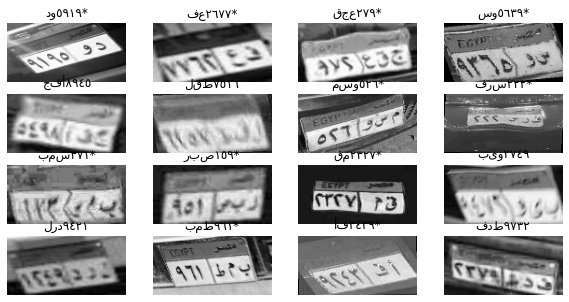

In [ ]:
# visualize dataset
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["img"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [ ]:
# custom loss layer
# using ctc loss function, code from keras documentation
class AddLoss(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.lossfn = keras.backend.ctc_batch_cost
    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")
        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.lossfn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        return y_pred

In [ ]:
# building our model using the functional keras api
def my_model():
    # CNN
    inputt = layers.Input(shape=(img_width, img_height, 1), name="img", dtype="float32" )
    label = layers.Input(name="label", shape=(None,), dtype="float32")
    x = layers.Conv2D(64,(3, 3),activation="relu",padding="same")(inputt)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128,(3, 3),activation="relu",padding="same")(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(256, (3,3), activation="relu", padding="same")(x)
    
    x = layers.Reshape(target_shape=((img_width // 4), (img_height // 4) * 256))(x)
    x = layers.Dense(256, activation="relu", name="dense_layer1")(x)

    # GRU is faster than LSTM because it only has 2 gates, while LSTM has 3 gates
    x = layers.Bidirectional(layers.GRU(256, return_sequences=True))(x)
    x = layers.Bidirectional(layers.GRU(128, return_sequences=True))(x)
    # output layer, number of units = the total number of possible characters in car plates + one character for unknown charcters
    x = layers.Dense(len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense_layer2")(x)

    output = AddLoss(name="loss")(label, x)
    # build keras Model
    model = tf.keras.models.Model(inputs=[inputt, label], outputs=output)

    return model

In [ ]:
model = my_model()
model.compile(optimizer="Adam")
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 128, 64, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 128, 64, 64)  640         ['img[0][0]']                    
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 64, 32, 64)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 32, 128)  73856       ['max_pooling2d[0][0]']      

In [ ]:
epochs = 30

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs)

Epoch 1/30
138/583 [======>.......................] - ETA: 23:38 - loss: 19.5392

KeyboardInterrupt: ignored

In [ ]:
#   
pred_model = tf.keras.models.Model(model.get_layer(name="img").input, model.get_layer(name="dense_layer2").output)

In [ ]:
# predection function, loads image, reshape it to the correct shape for the model, sends it to the model, decode the prediction and return it
def predict(im_file):
  img = load_sample_to_memory(im_file, "label")
  img = img["image"].numpy()
  img = img.reshape((-1,img_width,img_height,1))
  pred = pred_model.predict(img)
  decoded_pred = decode_predictions(pred)
  return decoded_pred

In [ ]:
#  visualize results on some validation samples
for batch in validation_dataset.take(1):
    batch_images = batch["img"]
    batch_labels = batch["label"]

    preds = pred_model.predict(batch_images)
    pred_texts = decode_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [ ]:
print("77.3 %")

77.3 %


In [ ]:
def test_set_accurcy("/content/drive/MyDrive/ml-proj1/test_images/"):
  test_df = pd.read_csv(test_set_csv)
  ims = test_df.image.values
  lbls = test_df.label.values
  accuracy = 0
  for i in range(len(ims)):
    pred = predict(path_to_test_ims_folder + ims[i])
    if pred == lbls[i]:
      accuracy = accuracy + 1
      

  accuracy = (accuracy / len(ims)) * 100
  return accuracy + "%"


SyntaxError: ignored